In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Read data

In [3]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [4]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month

data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [5]:
cols_to_fill = ['allies_planes', 'axis_planes', 'axis_tanks', 'allies_tanks']
data[cols_to_fill] = data[cols_to_fill].fillna(0)

In [6]:
mask = data[['allies_infantry', 'axis_infantry']].isnull().any(1)

In [7]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0) # * data['result_prop']

In [8]:
data['result_num'].value_counts()

-1.0    93
 1.0    34
 0.0     6
Name: result_num, dtype: int64

# 2. Supervised Learning

In [9]:
cols = [
    'allies_infantry', 'axis_infantry', 'allies_tanks', 'axis_tanks', 'allies_planes', 'axis_planes',
    'duration'

]

### KNN

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [11]:
# ?train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scale(data.loc[~mask, cols]), 
                                                data.loc[~mask, 'result_num'], 
                                                test_size=0.2, random_state=2019)


In [12]:
model = KNeighborsClassifier(n_neighbors=5)

In [13]:
model.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
ypred1 = model.predict(Xtest)

In [16]:
accuracy_score(ytest, ypred1)

0.5294117647058824

## Decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data.loc[~mask, cols], 
                                                data.loc[~mask, 'result_num'], 
                                                test_size=0.2, random_state=2019)


In [34]:
tree_model = DecisionTreeClassifier(random_state=2019)
tree_model.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2019, splitter='best')

In [35]:
accuracy_score(ytest, tree_model.predict(Xtest))

0.4117647058823529

In [36]:
Xtest.tail()

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_planes,axis_planes,duration
70,336700.0,140000.0,924.0,318.0,1054.0,0.0,1
126,1171800.0,270000.0,1600.0,772.0,0.0,0.0,1
27,498000.0,655000.0,1393.0,1389.0,1210.0,1070.0,1
4,50000.0,5000.0,58.0,498.0,0.0,0.0,1
19,55000.0,11500.0,100.0,0.0,0.0,0.0,1


# Visualize the graph

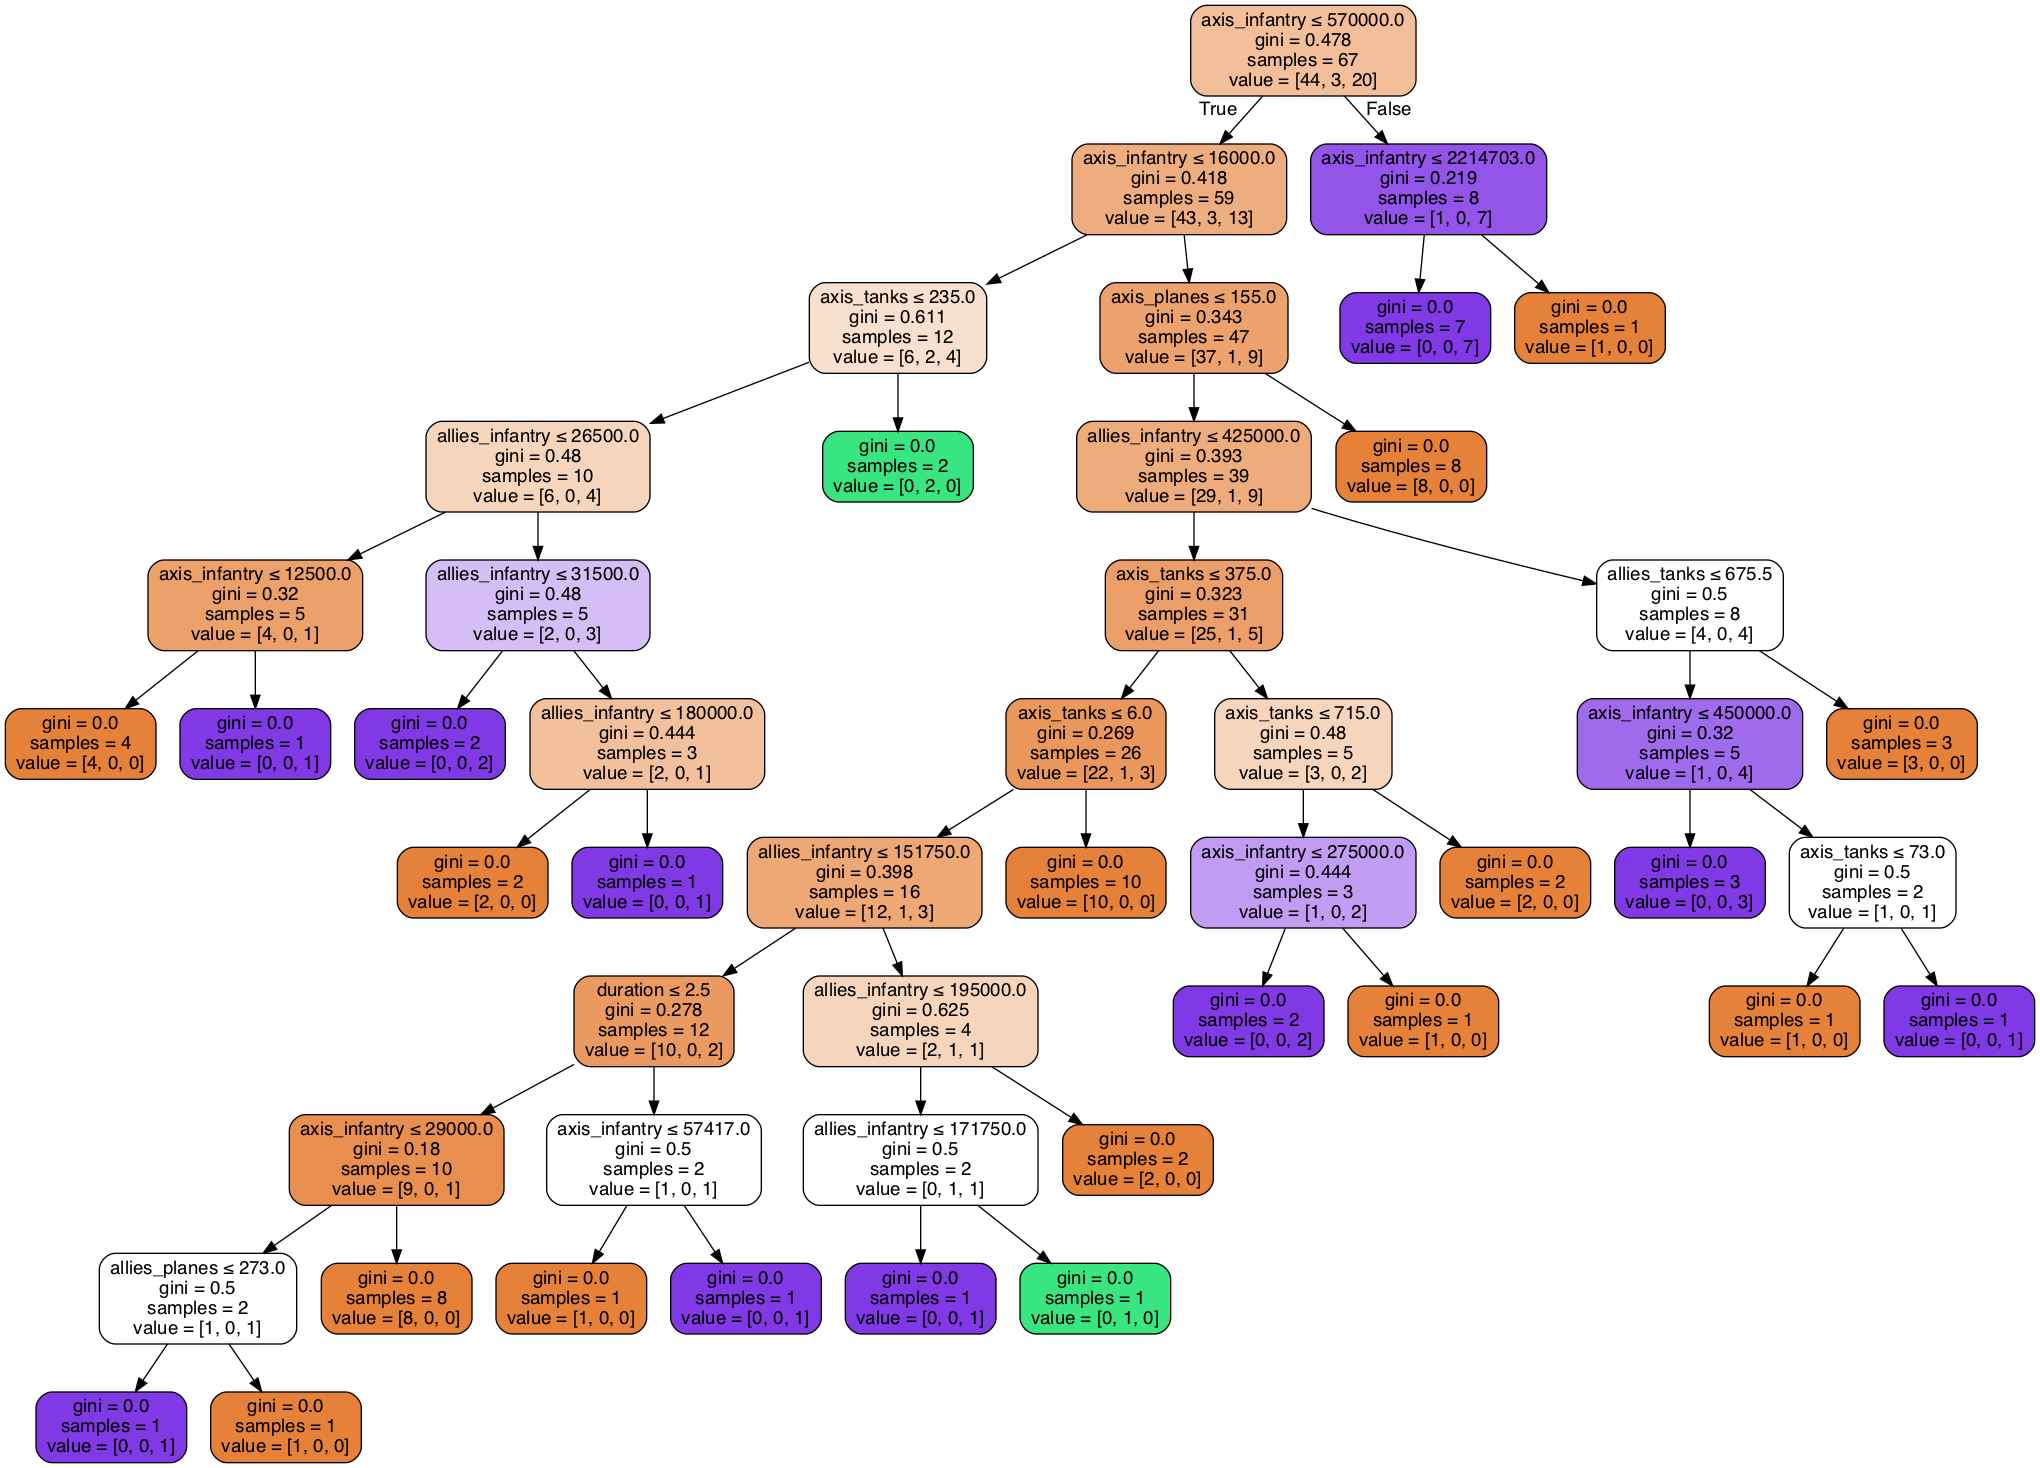

In [22]:
dot_data = StringIO()

export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())